In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/heart_disease/heart_disease.csv")
#data = data.drop(columns=['id'])
data.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [5]:
data.shape
data = data[:70000]

In [6]:
target = 'HeartDiseaseorAttack'

In [7]:
X = data.drop(columns=[target])
y = data[target]

In [8]:
#model_ctgan = CTGANSynthesizer(epochs=20)
model_ctgan = DPCTGANSynthesizer(verbose=True)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 3
Epoch 1, Loss G:  1.5868, Loss D: -0.5053, Epsilon: 1.5110
Epoch 2, Loss G:  0.5317, Loss D: -0.4299, Epsilon: 1.5828
Epoch 3, Loss G:  1.5986, Loss D: -0.2953, Epsilon: 1.6547
Epoch 4, Loss G:  0.7569, Loss D:  0.1218, Epsilon: 1.7266
Epoch 5, Loss G:  1.4987, Loss D:  0.1239, Epsilon: 1.7984
Epoch 6, Loss G:  0.5600, Loss D:  0.2551, Epsilon: 1.8703
Epoch 7, Loss G:  1.1480, Loss D: -0.2498, Epsilon: 1.9422
Epoch 8, Loss G:  1.0835, Loss D:  0.1035, Epsilon: 2.0140
Epoch 9, Loss G:  1.3118, Loss D: -0.1359, Epsilon: 2.0859
Epoch 10, Loss G:  0.7733, Loss D: -0.2047, Epsilon: 2.1578
Epoch 11, Loss G:  0.9617, Loss D:  0.1747, Epsilon: 2.2296
Epoch 12, Loss G:  0.9772, Loss D: -0.2365, Epsilon: 2.3015
Epoch 13, Loss G:  1.1778, Loss D: -0.1833, Epsilon: 2.3734
Epoch 14, Loss G:  0.9239, Loss D: -0.6149, Epsilon: 2.4423
Epoch 15, Loss G:  0.7453, Loss D:  0.1594, Epsilon: 2.4993
Epoch 16, Loss G:  0.4774, Loss D:  0.2754, Epsilon:

In [9]:
from utils.utils import save_models
save_models(model_ctgan, 'dpctgan3', 'heart_disease')

In [10]:
# plt.plot(losses)
# plt.show()

In [11]:
# plt.plot(tranformed_privacies)
# plt.show()

In [12]:
# plt.plot(original_losses)
# plt.show()

In [13]:
from utils.utils import load_models
model_ctgan = load_models('dpctgan3', 'heart_disease')

In [14]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [15]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [16]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.1416652]


## Fidelity

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test)

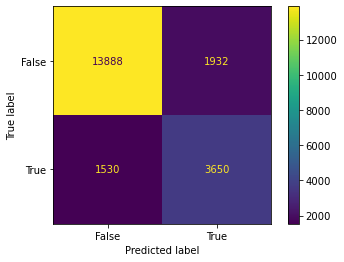

In [18]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [19]:
percentage, class1_ratio, class2_ratio = eval_fidelity(rr_pred, fr_pred)

In [20]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.7909047619047619
Accuracy of synthetic data:  0.753095238095238


In [21]:
print(class1_ratio, class2_ratio)

0.8004610951008646 0.5132170978627671


## Final plot

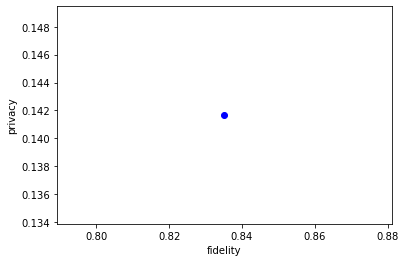

0.8351428571428572 [0.1416652]


In [22]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)